# Simulate Object Photo-z

Contact: Melissa Graham <br>
Last verified to run 2022-10-05 with LSST Science Pipelines version w40. <br>

## The CMNN Photo-z Estimator

The CMNN PZ Estimator is a toy estimator that is used primarily to evaluate observing strategies. 

A full description of the Color-Matched Nearest-Neighbors (CMNN) Photometric Redshift Estimator can be found in the following journal articles:
 * <a href="https://ui.adsabs.harvard.edu/abs/2018AJ....155....1G/abstract">Photometric Redshifts with the LSST: Evaluating Survey Observing Strategies</a> (Graham et al. 2018) 
 * <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....159..258G/abstract">Photometric Redshifts with the LSST. II. The Impact of Near-infrared and Near-ultraviolet Photometry</a> (Graham et al. 2020)

A full-featured version CMNN PZ Estimator can also be found on GitHub: https://github.com/dirac-institute/CMNN_Photoz_Estimator

## WARNINGS

**This notebook uses a *very simple* version of the CMNN PZ Estimator** with a leave-one-out analysis, using a sample of about one hundred thousand galaxies as both the test and training set.

This simplified version of the CMNN PZ Estimator:
 * does not handle sparse regions of color-redshift space as well as the full-featured version
 * does not have the capability to apply priors in magnitude or color
 * will not reproduce the photo-z quality demonstrated in the above papers
 * is not scalable to estimating photo-z for millions of DP0.2 Objects
 * can only estimate rudimentary photo-z for up to ~100000 galaxies
 * should not be used for any scientific studies

But it does make for a useful learning tool!

## Set up

In [1]:
import time
import numpy as np
import pandas
pandas.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import chi2

import datetime

In [2]:
import warnings
from astropy.units import UnitsWarning
warnings.simplefilter("ignore", category=UnitsWarning)

In [3]:
from lsst.rsp import get_tap_service, retrieve_query
service = get_tap_service()

## 1.0. Use the TAP service to retrieve true galaxies matched to Objects

True galaxies: `truth_type = 1`, true `redshift > 0.05`, true i-band mag < 25.0.

Matched Objects: observed apparent i-band magnitude < 25.2.

Use a small, arbitrary region near the center of the DC2 simulation.
Set radius such that ~100000 objects are retrieved.

**First, figure out the area needed to return about 100000 true galaxies with redshift > 0.05 and i-band magnitudes < 25.0.**

I figured out that a radius of 0.5 degrees is needed, as the following query returns 117762 objects.

This query takes 3 minutes.

In [6]:
query = "SELECT ra, dec, truth_type, redshift, scisql_nanojanskyToAbMag(flux_i) "\
        "FROM dp02_dc2_catalogs.TruthSummary "\
        "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 62.0, -37.0, 0.5)) = 1 "\
        "AND truth_type = 1 "\
        "AND redshift > 0.05 "\
        "AND scisql_nanojanskyToAbMag(flux_i) < 25.0 "
print(query)

SELECT ra, dec, truth_type, redshift, scisql_nanojanskyToAbMag(flux_i) FROM dp02_dc2_catalogs.TruthSummary WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 62.0, -37.0, 0.5)) = 1 AND truth_type = 1 AND redshift > 0.05 AND scisql_nanojanskyToAbMag(flux_i) < 25.0 


In [7]:
%%time
results = service.search(query)
print('Query returned %s matched objects.' % len(results))

Query returned 117762 matched objects.
CPU times: user 1.61 s, sys: 24.8 ms, total: 1.63 s
Wall time: 3min


In [8]:
results.to_table()

ra,dec,truth_type,redshift,scisql_nanojanskyToAbMag
deg,deg,,,
float64,float64,int64,float32,float64
61.8467204,-36.5247667,1,0.325309,24.3091465310797
61.9640682,-36.5256321,1,1.12998,23.80580226420572
61.9705901,-36.5012733,1,1.62033,24.165759373149236
61.959093,-36.5110122,1,0.617447,24.239239528823674
61.8810154,-36.5292858,1,1.04422,24.94735661872254
61.9295162,-36.5161534,1,0.946283,24.864696952960262
61.8423869,-36.5246084,1,0.951227,22.963896661932424
61.9535704,-36.5231842,1,0.817563,23.6514711897635


In [9]:
del results

**Now do the full query to get galaxy data.**

This takes much longer, 10 minutes.

In [10]:
query = "SELECT mt.id_truth_type AS mt_id_truth_type, "\
        "mt.match_objectId AS mt_match_objectId, "\
        "ts.truth_type AS ts_truth_type, "\
        "ts.redshift AS ts_redshift, "\
        "scisql_nanojanskyToAbMag(ts.flux_u) AS ts_mag_u, "\
        "scisql_nanojanskyToAbMag(ts.flux_g) AS ts_mag_g, "\
        "scisql_nanojanskyToAbMag(ts.flux_r) AS ts_mag_r, "\
        "scisql_nanojanskyToAbMag(ts.flux_i) AS ts_mag_i, "\
        "scisql_nanojanskyToAbMag(ts.flux_z) AS ts_mag_z, "\
        "scisql_nanojanskyToAbMag(ts.flux_y) AS ts_mag_y, "\
        "scisql_nanojanskyToAbMag(obj.u_cModelFlux) AS obj_cModelMag_u, "\
        "scisql_nanojanskyToAbMag(obj.g_cModelFlux) AS obj_cModelMag_g, "\
        "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, "\
        "scisql_nanojanskyToAbMag(obj.i_cModelFlux) AS obj_cModelMag_i, "\
        "scisql_nanojanskyToAbMag(obj.z_cModelFlux) AS obj_cModelMag_z, "\
        "scisql_nanojanskyToAbMag(obj.y_cModelFlux) AS obj_cModelMag_y, "\
        "scisql_nanojanskyToAbMagSigma(obj.u_cModelFlux,obj.u_cModelFluxErr) AS obj_cModelMagErr_u, "\
        "scisql_nanojanskyToAbMagSigma(obj.g_cModelFlux,obj.g_cModelFluxErr) AS obj_cModelMagErr_g, "\
        "scisql_nanojanskyToAbMagSigma(obj.r_cModelFlux,obj.r_cModelFluxErr) AS obj_cModelMagErr_r, "\
        "scisql_nanojanskyToAbMagSigma(obj.i_cModelFlux,obj.i_cModelFluxErr) AS obj_cModelMagErr_i, "\
        "scisql_nanojanskyToAbMagSigma(obj.z_cModelFlux,obj.z_cModelFluxErr) AS obj_cModelMagErr_z, "\
        "scisql_nanojanskyToAbMagSigma(obj.y_cModelFlux,obj.y_cModelFluxErr) AS obj_cModelMagErr_y "\
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "\
        "WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', 62.0, -37.0, 0.5)) = 1 "\
        "AND ts.truth_type = 1 "\
        "AND ts.redshift > 0.05 "\
        "AND scisql_nanojanskyToAbMag(obj.i_cModelFlux) < 25.2"
print(query)

SELECT mt.id_truth_type AS mt_id_truth_type, mt.match_objectId AS mt_match_objectId, ts.truth_type AS ts_truth_type, ts.redshift AS ts_redshift, scisql_nanojanskyToAbMag(ts.flux_u) AS ts_mag_u, scisql_nanojanskyToAbMag(ts.flux_g) AS ts_mag_g, scisql_nanojanskyToAbMag(ts.flux_r) AS ts_mag_r, scisql_nanojanskyToAbMag(ts.flux_i) AS ts_mag_i, scisql_nanojanskyToAbMag(ts.flux_z) AS ts_mag_z, scisql_nanojanskyToAbMag(ts.flux_y) AS ts_mag_y, scisql_nanojanskyToAbMag(obj.u_cModelFlux) AS obj_cModelMag_u, scisql_nanojanskyToAbMag(obj.g_cModelFlux) AS obj_cModelMag_g, scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, scisql_nanojanskyToAbMag(obj.i_cModelFlux) AS obj_cModelMag_i, scisql_nanojanskyToAbMag(obj.z_cModelFlux) AS obj_cModelMag_z, scisql_nanojanskyToAbMag(obj.y_cModelFlux) AS obj_cModelMag_y, scisql_nanojanskyToAbMagSigma(obj.u_cModelFlux,obj.u_cModelFluxErr) AS obj_cModelMagErr_u, scisql_nanojanskyToAbMagSigma(obj.g_cModelFlux,obj.g_cModelFluxErr) AS obj_cModelMagErr_g, s

In [11]:
%%time
results = service.search(query)
print('Query returned %s matched objects.' % len(results))

Query returned 139148 matched objects.
CPU times: user 9.24 s, sys: 113 ms, total: 9.36 s
Wall time: 9min 13s


In [12]:
results.to_table()

mt_id_truth_type,mt_match_objectId,ts_truth_type,ts_redshift,ts_mag_u,ts_mag_g,ts_mag_r,ts_mag_i,ts_mag_z,ts_mag_y,obj_cModelMag_u,obj_cModelMag_g,obj_cModelMag_r,obj_cModelMag_i,obj_cModelMag_z,obj_cModelMag_y,obj_cModelMagErr_u,obj_cModelMagErr_g,obj_cModelMagErr_r,obj_cModelMagErr_i,obj_cModelMagErr_z,obj_cModelMagErr_y
object,int64,int64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7939461442_1,1651413688361451864,1,0.94757,26.3058427470115,26.262990677035575,25.99727294543226,25.328347475979086,24.964310304383012,24.942522087205003,25.67119971109517,25.690666843715604,25.582660895102812,24.677558696921963,24.393951039948927,23.805063876350438,0.2814905106762819,0.09881716627024327,0.10595272765960834,0.08918215115641565,0.1857616549283062,0.1892847426850294
7939458371_1,1651413688361450903,1,0.951227,24.012065061670715,24.022136122568565,23.64937209495374,22.963896661932424,22.468743540313145,22.317251211216224,23.544280734193404,23.413564172191652,23.113793508665438,22.62828657560826,22.116756148170104,21.96312343360247,0.043740161690455595,0.012906328604594489,0.011536440850799409,0.01418060268473368,0.022797442389497165,0.03841308236014057
7940601535_1,1651413688361451151,1,1.14267,23.722529728049125,23.659142332646834,23.4785636183392,23.231070957070834,22.518944200541455,22.326057691697983,23.65467020016949,23.553670017829383,23.4203129469512,23.143128079975003,22.515910055861724,22.282745687545553,0.0443867300534122,0.015092832140177453,0.014036043894637779,0.021225288060865113,0.031697825176337034,0.04705549522001046
7941544989_1,1651413688361451141,1,1.30677,25.018205005376757,25.02733404852001,24.912468585849513,24.739469364808294,24.29434692278617,23.859778234399133,25.10028373869804,25.07253016792631,24.88055977702828,24.795541192683714,24.211676275310666,23.65962609551831,0.12184858540141114,0.03932990603429796,0.04004080738915426,0.0676912277974481,0.11184389958869213,0.13554839232350266
7940893415_1,1651413688361451140,1,1.14715,25.02654223067354,25.27259966917395,24.963122685922052,24.680755713205112,23.99050867863682,23.781213077947882,24.766378131970512,25.004930766751993,24.69624846808008,24.412891907314666,23.842810426159915,23.295592654108233,0.1018145758386794,0.04264790446126092,0.039080718079251967,0.054915581272572817,0.08834921853496036,0.10515133590955882
7938684807_1,1651413688361451139,1,0.77493,25.995730952509955,25.923103081023754,25.55343684494914,24.829142129777136,24.639741320465838,24.546675017703233,25.058048579907833,25.014892776491628,24.566490313046423,23.905812134388746,23.725362728965152,23.438820177442544,0.17461056548108908,0.057037129452648126,0.04605424147821615,0.04804825754094307,0.10704790788274669,0.15487888907382327
7939458378_1,1651413688361451138,1,0.951369,25.892694723681366,25.195409039620976,23.624181822317595,22.629486427828553,21.838394442304,21.49102092619676,25.485082907259258,25.07367595254306,23.668125840645185,22.719007456879563,21.89606268655879,21.524715937414886,0.2547684295284195,0.05913451738619321,0.019861163697796853,0.015470454363949353,0.019517265115332978,0.026901626092102764
7937797456_1,1651413688361451150,1,0.442611,24.89594441052745,23.74155366065451,22.41750671823505,22.085090284337515,21.922594095804428,21.829599884999453,25.03033165155266,23.661947032716025,22.291840250900982,21.949030115684515,21.790912110209746,21.66047346970847,0.18419635348877159,0.018750833823583366,0.005937621619642482,0.008446242096407427,0.018747123684285785,0.031786046860561364
7937698473_1,1651413688361451209,1,0.376742,24.39878289863953,23.783588960493383,22.909329295706165,22.608925297845406,22.40334921322499,22.229484445193172,24.610932797999112,23.797396812234762,22.924485483372628,22.6263718707063,22.492460872314773,22.382046000992467,0.10228895423728247,0.0173010310592126,0.009670337697680354,0.014355121368617298,0.032277558510225866,0.05049500765588388


### 1.1 Use numpy arrays

In the past they've proved quicker than pandas data frames, but, this might depend on architecture and number of objects. It is unconfirmed whether numpy is optimal for this application, but going with it for this demo.

In [14]:
# galaxy true redshifts
data_tz = np.asarray(results['ts_redshift'], dtype='float')

# galaxy true magnitudes
data_tm = np.transpose(np.asarray((results['ts_mag_u'],results['ts_mag_g'],\
                                   results['ts_mag_r'],results['ts_mag_i'],\
                                   results['ts_mag_z'],results['ts_mag_y']),\
                                  dtype='float' ) )

# object apparent magnitudes
data_om = np.transpose(np.asarray((results['obj_cModelMag_u'],results['obj_cModelMag_g'],\
                                   results['obj_cModelMag_r'],results['obj_cModelMag_i'],\
                                   results['obj_cModelMag_z'],results['obj_cModelMag_y']),\
                                  dtype='float' ) )

# object apparent magnitude errors
data_ome = np.transpose(np.asarray((results['obj_cModelMagErr_u'],results['obj_cModelMagErr_g'],\
                                    results['obj_cModelMagErr_r'],results['obj_cModelMagErr_i'],\
                                    results['obj_cModelMagErr_z'],results['obj_cModelMagErr_y']),\
                                   dtype='float' ) )

In [17]:
# true and object galaxy colors and color errors
data_tc = np.zeros( (len(data_om),5), dtype='float' )
data_oc = np.zeros( (len(data_om),5), dtype='float' )
data_oce = np.zeros( (len(data_om),5), dtype='float' )

data_tc[:,0] = data_tm[:,0] - data_tm[:,1]
data_tc[:,1] = data_tm[:,1] - data_tm[:,2]
data_tc[:,2] = data_tm[:,2] - data_tm[:,3]
data_tc[:,3] = data_tm[:,3] - data_tm[:,4]
data_tc[:,4] = data_tm[:,4] - data_tm[:,5]

data_oc[:,0] = data_om[:,0] - data_om[:,1]
data_oc[:,1] = data_om[:,1] - data_om[:,2]
data_oc[:,2] = data_om[:,2] - data_om[:,3]
data_oc[:,3] = data_om[:,3] - data_om[:,4]
data_oc[:,4] = data_om[:,4] - data_om[:,5]

data_oce[:,0] = np.sqrt( data_ome[:,0]**2 + data_ome[:,1]**2 )
data_oce[:,1] = np.sqrt( data_ome[:,1]**2 + data_ome[:,2]**2 )
data_oce[:,2] = np.sqrt( data_ome[:,2]**2 + data_ome[:,3]**2 )
data_oce[:,3] = np.sqrt( data_ome[:,3]**2 + data_ome[:,4]**2 )
data_oce[:,4] = np.sqrt( data_ome[:,4]**2 + data_ome[:,5]**2 )

In [ ]:
# del results

### 1.2 Plot color vs. redshift

If you want to see what the galaxy properties are like.

Note that the redshift distribution shows structure.
This is cosmic variance, an effect of using a small area.

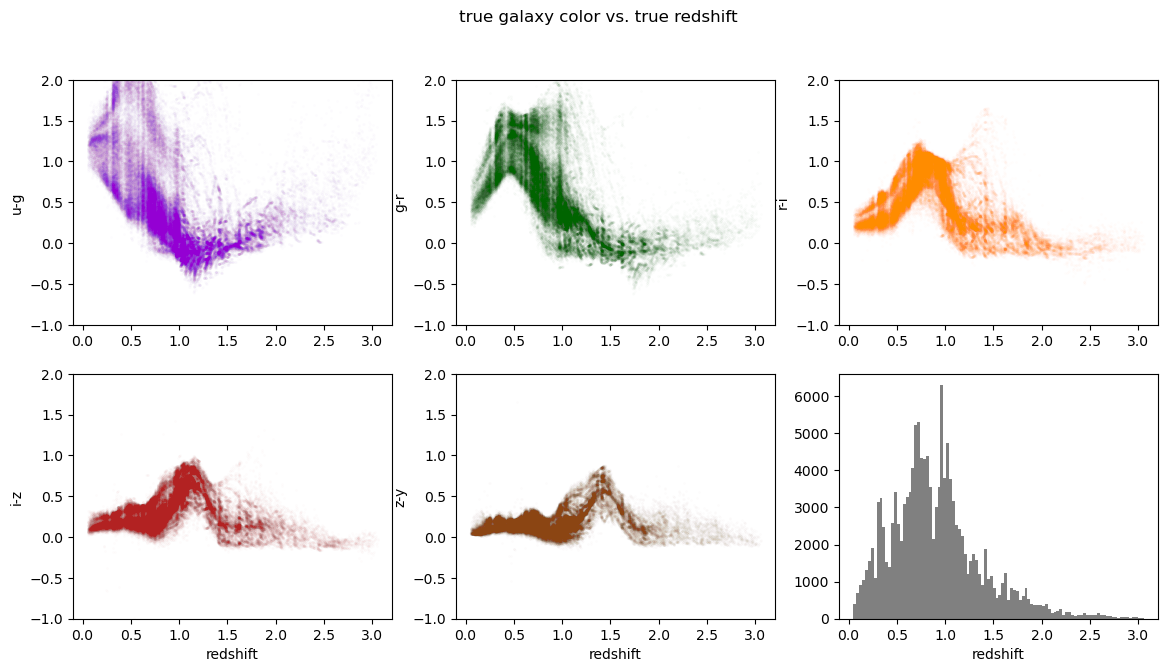

In [21]:
fig, axs = plt.subplots(2,3, figsize=(14, 7))
fig.suptitle('true galaxy color vs. true redshift')
axs[0,0].plot(data_tz, data_tc[:,0], 'o', ms=2, mew=0, alpha=0.01, color='darkviolet')
axs[0,0].set_ylabel('u-g')
axs[0,0].set_ylim([-1,2])
axs[0,1].plot(data_tz, data_tc[:,1], 'o', ms=2, mew=0, alpha=0.01, color='darkgreen')
axs[0,1].set_ylabel('g-r')
axs[0,1].set_ylim([-1,2])
axs[0,2].plot(data_tz, data_tc[:,2], 'o', ms=2, mew=0, alpha=0.01, color='darkorange')
axs[0,2].set_ylabel('r-i')
axs[0,2].set_ylim([-1,2])
axs[1,0].plot(data_tz, data_tc[:,3], 'o', ms=2, mew=0, alpha=0.01, color='firebrick')
axs[1,0].set_ylabel('i-z')
axs[1,0].set_xlabel('redshift')
axs[1,0].set_ylim([-1,2])
axs[1,1].plot(data_tz, data_tc[:,4], 'o', ms=2, mew=0, alpha=0.01, color='saddlebrown')
axs[1,1].set_ylabel('z-y')
axs[1,1].set_xlabel('redshift')
axs[1,1].set_ylim([-1,2])
axs[1,2].hist(data_tz, color='grey', bins=100)
axs[1,2].set_xlabel('redshift')
fig.show()

<br>

## 2.0 Estimate photo-z

This notebook uses a leave-one-out method: for each galaxy that we retrieved (i.e., each test galaxy), we use *all the other galaxies* and their true redshifts as the training set.

For each test galaxy, the estimator identifies a color-matched subset of training galaxies by calculating the Mahalanobis distance in color-space between the test galaxy and all training galaxies:

$D_M = \sum_{\rm 1}^{N_{\rm colors}} \frac{( c_{\rm test} - c_{\rm train} )^2}{ (\delta c_{\rm test})^2}$

where $c$ is the color of the test- or training-set galaxy, $\delta c_{\rm test}$ is the uncertainty in the test galaxy's color, and $N_{\rm color}$ is the number of colors measured for both the test- and training-set galaxy. 

A threshold value is then applied to all training-set galaxies to identify those which are well-matched in color: this is called the **CMNN subset** of training galaxies.

This threshold value is defined by the percent point function (PPF): e.g., if the number of degrees of freedom $N_{\rm color}=5$, PPF$=68\%$ of all training galaxies consistent with the test galaxy will have $D_M < 5.86$.

A training galaxy is then selected randomly from this subset of color-matched nearest-neighbors, and its redshift is used as the test-set galaxy's photometric redshift.

The standard deviation in redshifts of this subset of training galaxies is used as the uncertainty in the photo-_z_ estimate.

<br>

### 2.1 Set the tunable parameters

This simple version of the CMNN estimator takes just two tunable parameters:

(1) The percent point function (`cmnn_ppf`), as described above. The default is 0.68.

(2) The minimum number of colors (`cmnn_minNclr`) that a training-set galaxy must have in common with the test galaxy. The default is 5 (i.e., all five colors). This parameter could be lowered if magnitude cuts are applied, leaving some galaxies undetected in some bands.

In [ ]:
cmnn_ppf = 0.68 
cmnn_minNclr = 5

We make and use a thresholds lookup table because chi2.ppf is slow. As described above, the threshold values are based on the desired percent point function (PPF).

In [ ]:
cmnn_thresh_table = np.zeros(6, dtype='float')
for d in range(6):
    cmnn_thresh_table[d] = chi2.ppf(cmnn_ppf,d)
cmnn_thresh_table[0] = float(0.0000)

for d in range(6):
    print('degrees of freedom, threshold = ', d, cmnn_thresh_table[d])

<br>

### 2.2 Estimate the photo-z

Make arrays to hold photo-z for all of the galaxies

In [ ]:
data_pz = np.zeros(len(data_m), dtype='float') - 1.0
data_pze = np.zeros(len(data_m), dtype='float') - 1.0

<br>

**WARNING:** It takes ~30 minutes to do ~100000 galaxies (~1.5 minutes to do ~5000).

As a test, we can use `Ncalc` to only estimate photo-z for a subset of the galaxies.

In [ ]:
# Ncalc = len(data_c)
Ncalc = 5000

In [ ]:
%%time

t1 = datetime.datetime.now()

for i in range( Ncalc ):
    if (i == 100) | (i == 1000) | (i == Ncalc-1000):
        t2 = datetime.datetime.now()
        print(i, t2-t1, ((t2-t1)/float(i))*(float(Ncalc)), ' remaining' )
        
    DM  = np.nansum((data_oc[i,:] - data_tc[:,:])**2 / data_oce[i,:]**2, axis=1, dtype='float')
    DOF = np.nansum((data_oc[i,:]**2 + data_tc[:,:]**2 + 1.0) / (data_oc[i,:]**2 + data_tc[:,:]**2 + 1.0), axis=1, dtype='int')
    
    data_th = np.zeros(len(data_tc), dtype='float')
    for d in range(6):
        tx = np.where(DOF == d)[0]
        data_th[tx] = cmnn_thresh_table[d]
        del tx
    
    # reset the Mahalanobis distance for this 'test' galaxy to be very large
    # this will "leave out" the current 'test' galaxy from the 'training set'
    DM[i] = 99.9
        
    index = np.where( \
    ( DOF >= cmnn_minNclr ) & \
    ( data_th > 0.00010 ) & \
    ( DM > 0.00010 ) & \
    ( DM <= data_th ) )[0]
    
    if len(index) > 0:
        rival = np.random.choice(index, size=1, replace=False)[0]
        data_pz[i] = data_tz[rival]
        data_pze[i] = np.std( data_tz[index] )
        del rival
    else:
        data_pz[i] = float('nan')
        data_pze[i] = float('nan')
        
    del index, data_th, DOF, DM

#### 2.2.1 Quick check of success rate

In [ ]:
tx = np.where( np.isnan(data_pz) )[0]
print( len(tx), ' galaxies did not get a pz estimate' )
del tx

tx = np.where( data_pz > 0.0 )[0]
print( len(tx), ' galaxies did get a pz estimate' )
del tx

<br>

### 2.3 Plot the photo-z results

#### 2.3.1 Plot the photometric *versus* the true redshifts.

In [ ]:
tx = np.where( data_pz > 0.0 )[0]

fig = plt.figure(figsize=(4,4))
plt.plot( [0.0,3.0], [0.0,3.0], ls='solid', lw=1, color='firebrick')
plt.plot( data_tz[tx], data_pz[tx], 'o', ms=5, mew=0, alpha=0.1, color='grey' )
plt.xlabel('true redshift')
plt.ylabel('photometric redshift')
plt.show()

del tx

#### 2.3.2 Plot the photo-z uncertainty *versus* the photo-z accuracy.

The photo-z accuracy is the absolute value of the difference between the true and photometric redshifts.

Recall that the photo-z uncertainty is the standard deviation of the true redshifts of the training-set galaxies in the CMNN subset, as described in Section 2. The fact that a bunch of galaxies have an uncertainty of zero means there are galaxies with only 1 training-set galaxy in their CMNN subset. The full CMNN PZ Estimator treats such galaxies better (see Section 3).

In [ ]:
tx = np.where( data_pz > 0.0 )[0]

fig = plt.figure(figsize=(10,4))
plt.plot( np.abs(data_tz[tx]-data_pz[tx]), data_pze[tx],\
         'o', ms=5, mew=0, alpha=0.1, color='grey' )
plt.xlabel('photo-z accuracy')
plt.ylabel('photo-z uncertainty')
plt.show()

del tx

<br>

## 3.0 Future Work

(1) Generate a *separate* training set of ~200000 galaxies, and then apply it to a *separate* test set of many more galaxies. 

(2) Install the full CMNN PZ Estimator as a package, and demonstrate how to use it. This might take some modification. The full package features more parameters, and modules for statistical analysis and plotting. The additional parameters include magnitude and color priors, alternatives to randomly selecting from the CMNN subset, and more robust treatment of test-set galaxies with few training-set galaxies in the CMNN subset. 